In [1]:
import numpy as np
import sympy as smp
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter

## Solving an N-Body Pendulum System with Spring-like Rods using Lagrangian Mechanics

### (Physical Problem Statement on Rubric)

In this project, I look to simulate and visualize the motion of an **n-body pendulum system**, where each pendulum is connected by a spring rather than a rigid rod. Because of this, another degree of freedom-the radial extension of the mass-is added to the problem. This creates a system of equations that is essentially impossible to solve by hand.

To model this system, I apply **Lagrangian mechanics**—an aspect that we have been studying thoroughly throughout this course—which utilizes the conserved quantities to derive the coupled equations of motion. For a system with \( n \) masses, this results in \( 2n \) coupled second-order differential equations, where each mass contributes one angular and one radial coordinate.

In this specific notebook, I found it convenient to consider each mass and spring to be identical to avoid overcomplication, but it could be done with fairly little additional work.

I found it useful to derive the Lagrangian with the following:
- `sympy`
- `scipy.integrate.odeint`
- `matplotlib` / `manim`

Sympy was very simple to use because there is much documentation online about how to use it in similar contexts. These sources were very important for me in this notebook. By highlighting the use of sympy in the Lagrangian definition, I believe I partially address the 10th criterion in the rubric.

Odeint was the integrator I chose to use for this only because it was the one I used most frequently throughout this course. I'm sure there are other methods that may be more efficient, but this worked for me.

To animate, I again looked for similar pendulum animations online and derived mine from that. It is not a great animation, but it absolutely captures the motion of the system.


This notebook takes a very long time for my computer to run, especially for n greater than 3, but feel welcome to see how much your computer can handle.


In [2]:
#Initializing sympy constants and variables for the notebook

t,m,g,k,l = smp.symbols('t m g k l')

In [3]:
"""
This is the most powerful block of code within this notebook,
and has the ability to determine how many bodies will be in the 
pendulum system. I advise choosing a value much greater than 2,
as it probably will take too long.
"""

n = 2

In [4]:


# First, I create phi1 and r1 up to phin and rn

phis = smp.symbols([f'phi_{i+1}' for i in range(n)], cls=smp.Function)
rs = smp.symbols([f'r_{i+1}' for i in range(n)], cls=smp.Function)

#I make each a function of time

#phis_t = [phi(t) for phi in phis]
#rs_t = [r(t) for r in rs]

phis_t = [smp.Function(f'phi{i+1}')(t) for i in range(n)]
rs_t = [smp.Function(f'r{i+1}')(t) for i in range(n)]

# First derivatives

phis_dot = [smp.diff(phi_t, t) for phi_t in phis_t]
rs_dot = [smp.diff(r_t, t) for r_t in rs_t]

# Second derivatives

phis_dbldot = [smp.diff(dot, t) for dot in phis_dot]
rs_dbldot = [smp.diff(dot, t) for dot in rs_dot]

# Creating dictionaries that make for easy indexing throughout notebook

phi_data = {
    f'phi{i+1}': {
        'norm': phis_t[i],
        'dot': phis_dot[i],
        'dbldot': phis_dbldot[i]
    }
    for i in range(n)
}

r_data = {
    f'r{i+1}': {
        'norm': rs_t[i],
        'dot': rs_dot[i],
        'dbldot': rs_dbldot[i]
    }
    for i in range(n)
}




In [5]:
#Next, I create generalized position coordinates to make the Lagrangian calculation easier

x_data = {}
y_data = {}

#Each coordinate x_i and y_i is a summation of the coordinates before it plus (l+r_i)*cos(phi_i) for x_i
#and minus (l+r_i)*sin(phi_i) for y_i, where phi is defined as the angle from the x axis

for i in range(n):
    
    #We sum over all previous x and y and add addtional term
    
    xi_expr = sum((l + r_data[f'r{j+1}']['norm']) * smp.cos(phi_data[f'phi{j+1}']['norm']) for j in range(i + 1))
    yi_expr = -sum((l + r_data[f'r{j+1}']['norm']) * smp.sin(phi_data[f'phi{j+1}']['norm']) for j in range(i + 1))
    
    #We append each x and y to a data array with length n
    
    x_data[f'x{i+1}'] = xi_expr
    y_data[f'y{i+1}'] = yi_expr

In [6]:
#We can take the time derivative of x and y to find velocity for kinetic energy

x_dot_data = {f'x{i+1}': smp.diff(x_data[f'x{i+1}'], t) for i in range(n)}
y_dot_data = {f'y{i+1}': smp.diff(y_data[f'y{i+1}'], t) for i in range(n)}


# Because we're calculating in SymPy, the expressions for the Lagrangian are simple to code

T = (1/2) * m * sum(x_dot_data[f'x{i+1}']**2 + y_dot_data[f'y{i+1}']**2 for i in range(n))


U = m * g * sum(y_data[f'y{i+1}'] for i in range(n)) + sum((1/2) * k * r_data[f'r{i+1}']['norm']**2 for i in range(n))

# Lagrangian
L = T - U

In [7]:
print("The Lagrangian for this system is: ")
L


The Lagrangian for this system is: 


-g*m*(-2*(l + r1(t))*sin(phi1(t)) - (l + r2(t))*sin(phi2(t))) - 0.5*k*r1(t)**2 - 0.5*k*r2(t)**2 + 0.5*m*(((-l - r1(t))*cos(phi1(t))*Derivative(phi1(t), t) - sin(phi1(t))*Derivative(r1(t), t))**2 + (-(l + r1(t))*sin(phi1(t))*Derivative(phi1(t), t) + cos(phi1(t))*Derivative(r1(t), t))**2 + ((-l - r1(t))*cos(phi1(t))*Derivative(phi1(t), t) + (-l - r2(t))*cos(phi2(t))*Derivative(phi2(t), t) - sin(phi1(t))*Derivative(r1(t), t) - sin(phi2(t))*Derivative(r2(t), t))**2 + (-(l + r1(t))*sin(phi1(t))*Derivative(phi1(t), t) - (l + r2(t))*sin(phi2(t))*Derivative(phi2(t), t) + cos(phi1(t))*Derivative(r1(t), t) + cos(phi2(t))*Derivative(r2(t), t))**2)

In [8]:
"""
We now have our lagrangian, so we can calculate our (2n) Euler Lagrange Equations. Remember,
there are (2n) now because of the additional degree of freedom. We will iterate through n and use
smp.diff() to take derivatives. Each equation will be stored in the array EL_eqs[]. 

"""
EL_eqs = []

for i in range(n):
    
    # Creating dummy variables
    phi = phi_data[f'phi{i+1}']['norm']
    phi_dot = phi_data[f'phi{i+1}']['dot']
    
    
    # Euler Lagrange equation for phi_i
    EL_phi = smp.diff(L, phi) - smp.diff(smp.diff(L, phi_dot), t)
    EL_eqs.append(EL_phi.simplify())
    
    #creating dummy variables
    
    r = r_data[f'r{i+1}']['norm']
    r_dot = r_data[f'r{i+1}']['dot']  
    
    #Euler-Lagrange equation for r_i

    EL_r = smp.diff(L, r) - smp.diff(smp.diff(L, r_dot), t)
    EL_eqs.append(EL_r.simplify())

In [9]:
EL_eqs[1]

2.0*g*m*sin(phi1(t)) - 1.0*k*r1(t) - 1.0*l*m*sin(phi1(t) - phi2(t))*Derivative(phi2(t), (t, 2)) + 1.0*l*m*cos(phi1(t) - phi2(t))*Derivative(phi2(t), t)**2 + 2.0*l*m*Derivative(phi1(t), t)**2 + 2.0*m*r1(t)*Derivative(phi1(t), t)**2 - 1.0*m*r2(t)*sin(phi1(t) - phi2(t))*Derivative(phi2(t), (t, 2)) + 1.0*m*r2(t)*cos(phi1(t) - phi2(t))*Derivative(phi2(t), t)**2 - 2.0*m*sin(phi1(t) - phi2(t))*Derivative(phi2(t), t)*Derivative(r2(t), t) - 1.0*m*cos(phi1(t) - phi2(t))*Derivative(r2(t), (t, 2)) - 2.0*m*Derivative(r1(t), (t, 2))

In [10]:
"""
We will now isolate the second derivatives of each phi and each r to prepare for
the odeint solving technique. The sympy.solve() command will solve for each second derivative,
but is also a time-killer due to the complexity. This cell will take a while.
"""

#Creating a list of the second derivatives

second_derivs = tuple(val for pair in zip(
    (phi_data[f'phi{i+1}']['dbldot'] for i in range(n)),
    (r_data[f'r{i+1}']['dbldot'] for i in range(n))
) for val in pair)


#Solving for the second derivatives (uncoupling the equations)

sols = smp.solve(EL_eqs, second_derivs, simplify=False, rational=False)

In [11]:
"""
The next step is to switch from our symbolic functions to real python expressions. The sympy.lambdify()
command achieves this. However, we need to still prepare to solve the ode. To do so,
we need to create a vector like [phi_i, phi_i_dot] but keep them isolated. So, the functions w and v
are the derivatives of phi and r, respectively, and will be used to solve with odeint. This is the
technique we used in class, but now it is a bit more intense with the added deg. of freedom.

"""


lambdified_funcs = {}



# We want to get the variables out of the dictionary for smoother coding

phi_funcs  = [phi_data[f'phi{i}']['norm'] for i in range(1, n + 1)]
r_funcs    = [r_data[f'r{i}']['norm'] for i in range(1, n + 1)]
phi_dots   = [phi_data[f'phi{i}']['dot'] for i in range(1, n + 1)]
r_dots     = [r_data[f'r{i}']['dot'] for i in range(1, n + 1)]


#Argument list that will be passed to the big functions

full_args = [m, k, g, l] + phi_funcs + r_funcs + phi_dots + r_dots

#Will now create dphi/dt, dw/dt, dr/dt, dv/dt functions for i in n

#dw/dt and dv/dt eqs are the acceleration terms (second derivatives)

for i in range(1, n + 1):
    
    # Second derivative functions, passing large list of parameters
    
    dw_func = smp.lambdify(full_args, sols[phi_data[f'phi{i}']['dbldot']])
    dv_func = smp.lambdify(full_args, sols[r_data[f'r{i}']['dbldot']])

    # First derivatives, setting equal to themselves basically
    
    dphi_func = smp.lambdify(phi_data[f'phi{i}']['dot'], phi_data[f'phi{i}']['dot'])
    dr_func   = smp.lambdify(r_data[f'r{i}']['dot'], r_data[f'r{i}']['dot'])

    # Storing in list
    
    lambdified_funcs[f'dw{i}dt_f'] = dw_func
    lambdified_funcs[f'dphi{i}dt_f'] = dphi_func
    lambdified_funcs[f'dv{i}dt_f'] = dv_func
    lambdified_funcs[f'dr{i}dt_f'] = dr_func

In [12]:
#Function to pass through odeint(), essentially the derivatives of the expressions

def dSdt(S, t):
    dSdt_list = []

    #First, I unpack the terms within S, setting them equal to simple variables
    
    phis = []
    ws = []
    rs = []
    vs = []

    
    for i in range(n):
        phis.append(S[2 * i])       # phi_i
        ws.append(S[2 * i + 1])     # w_i

    for i in range(n):
        rs.append(S[(2 * n) + (2 * i)])     # r_i
        vs.append(S[(2 * n) + (2 * i) + 1]) # v_i

    #Next, I build the input list to be in the same form as I will pass my y0 argument
    
    inputs = [m, g, k, l] + phis + rs + ws + vs

    #I now create solvable quantities that depend on the passed parameters created in previous cell
    
    for i in range(n):
        dphi = lambdified_funcs[f'dphi{i+1}dt_f'](ws[i])
        dw   = lambdified_funcs[f'dw{i+1}dt_f'](*inputs)
        dSdt_list.extend([dphi, dw])

    # Doing equivalent for r_i terms
    
    for i in range(n):
        dr = lambdified_funcs[f'dr{i+1}dt_f'](vs[i])
        dv = lambdified_funcs[f'dv{i+1}dt_f'](*inputs)
        dSdt_list.extend([dr, dv])

    return dSdt_list

In [13]:
"""
This block of code is pretty fun, it randomly generates the initial conditions for the system
based on an arbitrary n. You of course can set your own y0, but make sure it is of the form
y0 = [phi1, w1, ...., phin, wn, r1, v1, ..., rn, vn]

The initial conditions are generated uniformly between two set boundaries.

(Interactivity Criterion in Rubric)
"""

y0_n = []


for i in range(n):
    y0_n.append(np.random.uniform(low=0, high=np.pi))
    y0_n.append(np.random.uniform(low=-3, high=3)) 
        
for i in range(n):
    y0_n.append(np.random.uniform(low=-4, high=4))
    y0_n.append(np.random.uniform(low=-5, high=5))
        
    


In [14]:
#We now have all the required code to solve for the phis and rs

#Initializing the parameters created with sympy

t = np.linspace(0,20,1000)
g=9.81
l=1
m=1
k=10

#Calling odeint to solve

ans = odeint(dSdt, y0=y0_n, t=t)

### Problem Solved!

The ans array now has all of our solution encoded within it. The array must be rotated in order to access the solutions. The first half of even rows are the phis, while the first half of odd rows are the phi_dots. The second half of even rows are the rs, and the second half of the odd rows are the r_dots

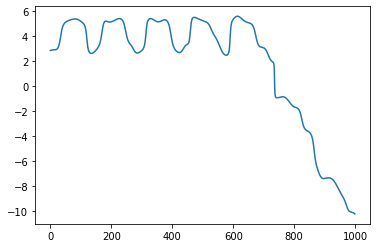

In [15]:
plt.plot(ans.T[0])

In [16]:
#This function will generate the x and y coordinates for each mass by unencoding the info
#in phi and r


def get_positions(phi_list, r_list, l):
    """
    Accepts:
    phi_list: list of arrays [phi1(t), phi2(t), ..., phin(t)]
    r_list:   list of arrays [r1(t),   r2(t),   ..., rn(t)]
    
    Returns:
      xs, ys: arrays of shape (n, len(t))
    """
    n = len(phi_list)
    num_t = len(phi_list[0])
    xs = np.zeros((n, num_t))
    ys = np.zeros((n, num_t))

    x = np.zeros(num_t)
    y = np.zeros(num_t)

    for i in range(n):
        r_total = l + r_list[i]
        dx = r_total * np.cos(phi_list[i])
        dy = -r_total * np.sin(phi_list[i])
        x += dx
        y += dy
        xs[i] = x
        ys[i] = y

    return xs, ys

In [17]:
#Implementing the info from my previous markdown cell

phi_list = [ans.T[2*i]   for i in range(n)]
r_list   = [ans.T[(2*i)+(2*n)] for i in range(n)]


xs, ys = get_positions(phi_list, r_list, l)






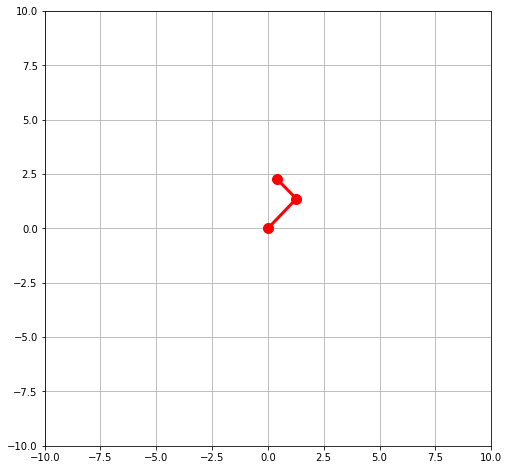

In [18]:
"""
The animation function is basic and not manim, but it does work. I found a video online about
animating these pendulum systems and I adapted my code from there.
"""

def animate(i):
    x_points = [0] + [xs[j][i] for j in range(n)]
    y_points = [0] + [ys[j][i] for j in range(n)]
    ln1.set_data(x_points, y_points)
    return ln1,
    
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.grid()
ln1, = plt.plot([], [], 'ro-', lw=3, markersize=10)
ax.set_ylim(-10,10)
ax.set_xlim(-10,10)
ani = animation.FuncAnimation(fig, animate, frames=1000, interval=50)
ani.save('spring_pendulum.gif', writer='pillow', fps=50)

In [23]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

(<AxesSubplot:title={'center':'Phase Plot of Bob 2'}, xlabel='phi_2', ylabel='phi_2_dot'>,
 <matplotlib.lines.Line2D at 0x7fd93b43a198>)

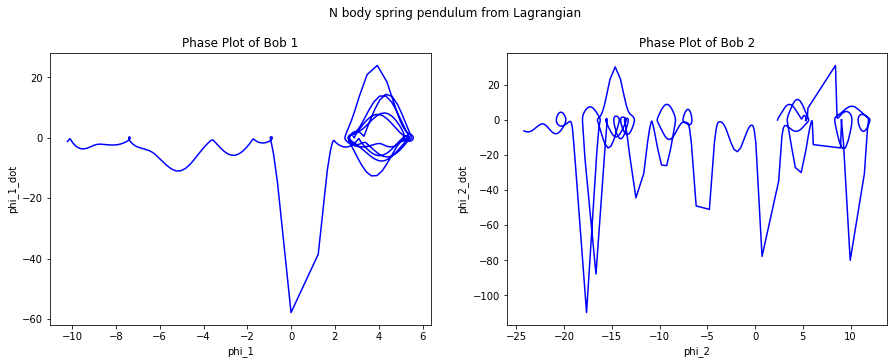

In [29]:


fig = plt.figure(figsize=(15,5))
overall_title = 'N body spring pendulum from Lagrangian'
               
fig.suptitle(overall_title, va='baseline')
    
# first plot: phi plot 
ax_a = fig.add_subplot(1,2,1)                  

start, stop = start_stop_indices(t, 0, 20)    
plot_y_vs_x(ans.T[0][start : stop], ans.T[1][start : stop], 
            axis_labels=("phi_1", "phi_1_dot"),
            color='blue',
            label=None, 
            title="Phase Plot of Bob 1", 
            ax=ax_a)    
                              
# second plot: phi_dot plot 
ax_b = fig.add_subplot(1,2,2)                  

start, stop = start_stop_indices(t, 0, 20)    
plot_y_vs_x(ans.T[2][start : stop], ans.T[3][start : stop], 
            axis_labels=("phi_2", "phi_2_dot"),
            color='blue',
            label=None, 
            title="Phase Plot of Bob 2", 
            ax=ax_b)    

Obviously, because of the randomnized initial conditions, every phase plot will appear different. But I know that each plot will be nessy and chaotic, and not a single path will be repeated by a given bob. This highlights the messiness of this problem and the overall idea of chaos and its appearance in these systems.